# Imports

In [58]:
import folium
import pandas as pd
import numpy as np

import time
from datetime import datetime

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchmetrics
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from watermark import watermark

import joblib

# Toolbox

In [59]:
def get_dates():
    today = datetime.now()

    today_rounded_down = today.replace(minute=0, second=0, microsecond=0)

    one_year_ago = today - timedelta(days=365)

    one_year_ago_rounded = one_year_ago.replace(minute=0, second=0, microsecond=0)
    if one_year_ago.minute != 0 or one_year_ago.second != 0 or one_year_ago.microsecond != 0:
        one_year_ago_rounded += timedelta(hours=1)

    formatted_today_rounded_down = today_rounded_down.strftime("%Y-%m-%dT%H:%M:%S")
    formatted_one_year_ago_rounded = one_year_ago_rounded.strftime("%Y-%m-%dT%H:%M:%S")

    return formatted_one_year_ago_rounded, formatted_today_rounded_down

class CustomDataset(Dataset):
    def __init__(self, feature_array, label_array, transform=None):

        self.x = feature_array
        self.y = label_array
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return self.y.shape[0]


class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, adam_ = False):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.adam_ = adam_

        self.save_hyperparameters(ignore=['model'])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = F.mse_loss(logits, true_labels)
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = F.mse_loss(logits, true_labels)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        if self.adam_:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer
    
class PyTorchLSTM_UNI(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PyTorchLSTM_UNI, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

def window(dataset, window_size = 5):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-window_size):
            feature = dataset[i:i+window_size]
            target = dataset[i+window_size:i+window_size+1]
            X.append(feature)
            y.append(target)

        X_r = torch.tensor(np.array(X))
        y_r = torch.tensor(np.array(y))
        return X_r.float(), y_r.float()

def loss_metrics(actual, pred_):
        mse_ = F.mse_loss(torch.tensor(actual.flatten()),
                          torch.tensor(pred_))
        rmse_ = np.sqrt(mse_)

        return mse_, rmse_
    
def compute_mse(model, dataloader, device=None):
    if device is None:
        device = torch.device("cpu")
    model = model.eval()

    mse_loss = 0.0
    total_examples = 0

    with torch.no_grad():
        for idx, (features, labels) in enumerate(dataloader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            predictions = model(features)

            # Calculate MSE loss
            mse_loss += F.mse_loss(predictions, labels).item()
            total_examples += features.size(0)

    return mse_loss / total_examples

def predict(model, features, device=None):
    if device is None:
        device = torch.device("cpu")
    model = model.eval()

    with torch.no_grad():
        features = features.to(device)

        # Forward pass
        predictions = model(features)

    return predictions


def rollout(model, current_set, step=24, verbose=True):
        forecast_scaled = []
        if verbose:
            print('Running...')

        with torch.no_grad():
            for i in range(step):
                print(f'{i}/{step}', end='\r')
                prediction = model(current_set.reshape(1, -1)).flatten()
                forecast_scaled.append(prediction.item())
                current_set = current_set[1:]
                current_set = torch.cat((current_set, prediction), dim=0)

            if verbose:
                print('Completed')

            forecast = pd.Series(forecast_scaled)
            results_ = np.array(forecast.values).squeeze()

        return results_  

def rollout_randomforest(model, current_set, step=24, verbose=True):
        forecast_scaled = []
        if verbose:
            print('Running...')

        with torch.no_grad():
            for i in range(step):
                print(f'{i}/{step}', end='\r')
                prediction = model.predict(current_set.reshape(1, -1))
                forecast_scaled.append(prediction.item())
                current_set = current_set[1:]
                current_set = torch.cat((current_set, torch.tensor(prediction)), dim=0)

            if verbose:
                print('Completed')

            forecast = pd.Series(forecast_scaled)
            results_ = np.array(forecast.values).squeeze()

        return results_  

# Data Module

In [60]:
class WeatherDataModule(L.LightningDataModule):
    def __init__(self, data_dir="data\current_weather_data.csv", index_='timestamp', 
                 column=2, batch_size=64, window_size=5, normalize_=False,
                 date_range = None, step_ = 24):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.index_ = index_
        self.column = column
        self.date_range = date_range
        self.window_size = window_size
        self.step_ = step_

        self.normalize_ = normalize_

    def prepare_data(self):
        df_ = pd.read_csv(self.data_dir, index_col=self.index_, parse_dates=True)
        if self.date_range != None:
            df_ = df_[self.date_range]
        
        if self.column == None:
            self.df = df_
        else:
            self.df = df_.iloc[:,self.column]
        
        if self.normalize_:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.df.values.reshape(-1, 1))
            self.df = self.normalize(self.df)

        self.windows, self.targets = self.window_step(self.df, self.step_)
        self.windows, self.targets = self.windows.squeeze(), self.targets.squeeze()

    def window_step(self, dataset, step_ ):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-self.window_size - step_):
            feature = dataset[i:i+self.window_size]
            target = dataset[i+self.window_size:i+self.window_size+step_]
            X.append(feature)
            y.append(target)

        X_r = torch.tensor(np.array(X))
        y_r = torch.tensor(np.array(y))
        return X_r.float(), y_r.float()
    
    def normalize(self, series):
        return pd.DataFrame(self.scaler.fit_transform(series), index=series.index)
    
    def inverse_normalze(self, series):
        return pd.DataFrame(self.scaler.inverse_transform(series), index=series.index)
    
    #TODO: Normalize a single column

    def setup(self, stage: str):
        split = [round(len(self.targets) * 0.7), round(len(self.targets) * 0.9)]

        self.f_train, self.t_train = self.windows[:split[0]], self.targets[:split[0]]
        self.f_valid, self.t_valid = self.windows[split[0]:split[1]], self.targets[split[0]:split[1]]
        self.f_test, self.t_test = self.windows[split[1]:], self.targets[split[1]:]

        print(f'Train: {self.f_train.shape}\nValid: {self.f_valid.shape}\nTest: {self.f_test.shape}')

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    # def predict_dataloader(self):
    #     return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)


## Visually Inspect Data Module

In [61]:
window_size = 24 * 3 
step = 24

In [62]:
#TODO: Add visual inspection graphs

Train: torch.Size([5983, 72, 5])
Valid: torch.Size([1709, 72, 5])
Test: torch.Size([855, 72, 5])


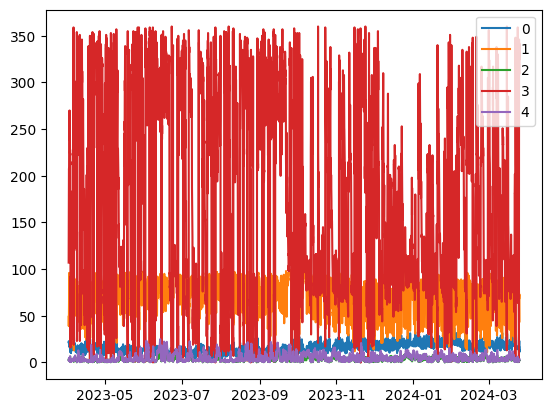

In [63]:
dm = WeatherDataModule(window_size=window_size, column=None,batch_size=32, step_=24, normalize_=True)
dm.prepare_data()
dm.setup('')

plt.plot(dm.inverse_normalze(dm.df))
plt.legend(dm.df.columns)
plt.show()

# Training

In [66]:

window_size = 24 * 3
step = 24

dm = WeatherDataModule(window_size=window_size, column=None,batch_size=32, step_=step, normalize_=True)

print('\n\n')

dm.prepare_data()
dm.setup('')

train_models = False
load_models = True

rfr = False
xgb_ = False
knn = False
ridge = True


if train_models:

    if rfr:
        start_time = time.time()

        print('Training Random Forest Regressor...')
        
        rf_regressor_1 = RandomForestRegressor(n_estimators=100, random_state=42)
        

        rf_regressor_1.fit(dm.f_train.reshape(-1, window_size * 5), dm.t_train[:,:,2])

        end_time = time.time()

        elapsed_minutes = (end_time - start_time) / 60
        print(f"Elapsed minutes: {elapsed_minutes}")
        print('\n\n')

        joblib.dump(rf_regressor_1, f'models/random_forest_model_ws_{window_size}_s_{step}.pkl')
            
    if xgb_:
        start_time = time.time()

        print('Training XGBoost Model...')
        
        rf_regressor_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', learning_rate=0.01,
                                                max_depth=3, n_estimators=1000,
                                                objective='reg:linear', random_state=0)
        
        

        rf_regressor_xgb.fit(dm.f_train.reshape(-1, window_size * 5), dm.t_train[:,:,2],
                                eval_set=[(dm.f_valid.reshape(-1, window_size * 5), dm.t_valid[:,:,2])], 
                                early_stopping_rounds=10, 
                                verbose=False)

        end_time = time.time()

        elapsed_minutes = (end_time - start_time) / 60
        print(f"Elapsed minutes: {elapsed_minutes}")
        print('\n\n')

        model_path = f"models/xgboost_model_ws_{window_size}_s_{step}.bin"
        rf_regressor_xgb.save_model(model_path)  
            
    if knn:
        start_time = time.time()
        
        print('Training KNN Regressor...')
        knn_regressor = KNeighborsRegressor(n_neighbors=10) 
        knn_regressor.fit(dm.f_train.reshape(-1, window_size * 5), dm.t_train[:,:,2])

        end_time = time.time()

        elapsed_minutes = (end_time - start_time) / 60
        print(f"Elapsed minutes: {elapsed_minutes}")
        print('\n\n')

        joblib.dump(knn_regressor, f'models/knn_regressor_model_ws_{window_size}_s_{step}.pkl')

    if ridge:
        start_time = time.time()

        print('Training ridge Regressor...')
        
        ridge_model = Ridge(alpha=0.1)  

        ridge_model.fit(dm.f_train.reshape(-1, window_size * 5), dm.t_train[:,:,2])

        end_time = time.time()

        elapsed_minutes = (end_time - start_time) / 60 
        print(f"Elapsed minutes: {elapsed_minutes}")    
        print('\n\n')

        joblib.dump(ridge_model, f'models/ridge_regressor_model_ws_{window_size}_s_{step}.pkl')
    

elif load_models:
    rfr_model = joblib.load(f'models/random_forest_model_ws_{window_size}_s_{step}.pkl')
    xgb_model = xgb.XGBRegressor()
    xgb_model.load_model(f'models/xgboost_model_ws_{window_size}_s_{step}.bin')
    knn_model = joblib.load(f'models/knn_regressor_model_ws_{window_size}_s_{step}.pkl')
    ridge_model = joblib.load(f'models/ridge_regressor_model_ws_{window_size}_s_{step}.pkl')

    print('Models loaded...')
        




Train: torch.Size([5983, 72, 5])
Valid: torch.Size([1709, 72, 5])
Test: torch.Size([855, 72, 5])
Models loaded...


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


# Testing

Mean MSE for Random Forest: 0.006514579310861607
Mean MSE for XGBoost: 0.00722540495917201
Mean MSE for kNN: 0.0062400600872933865
Mean MSE for ridge: 0.007570259313094772
Mean MSE for Average: 0.005522252276713462


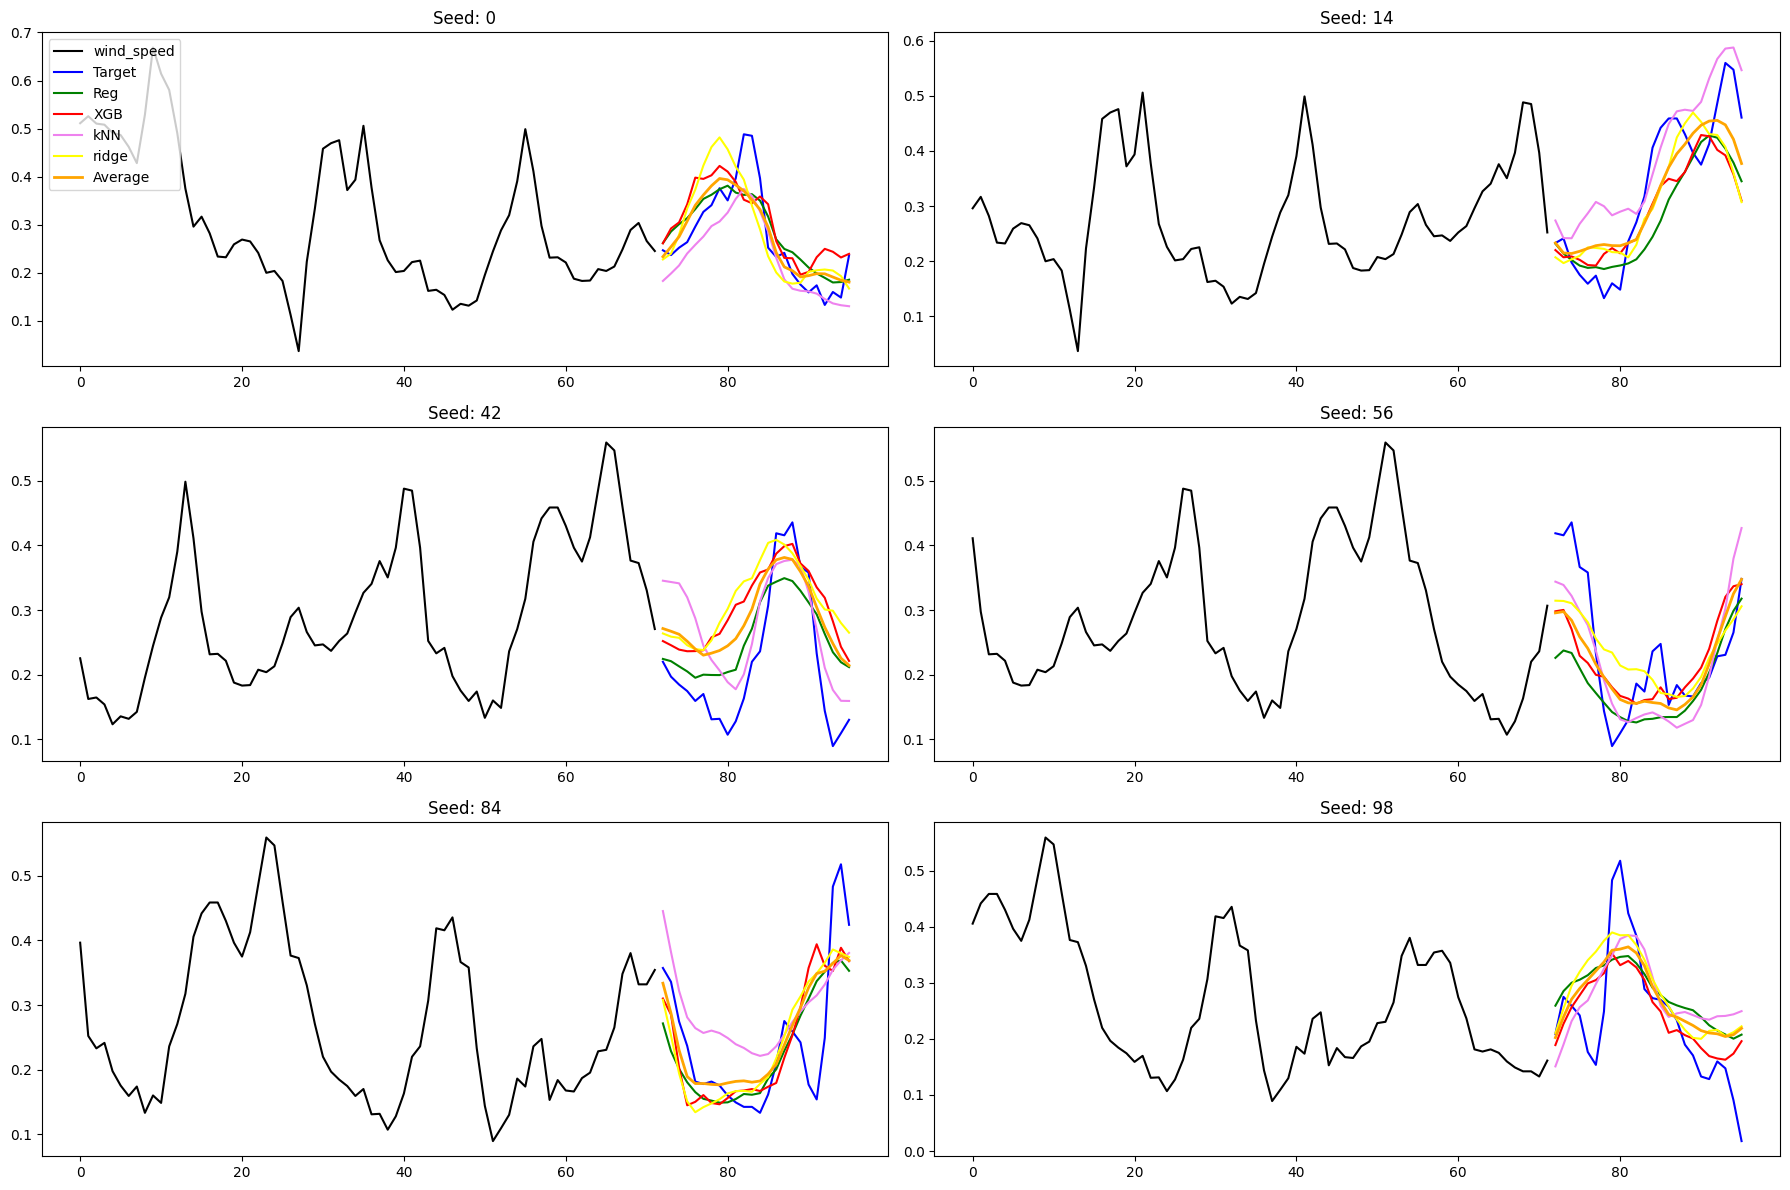

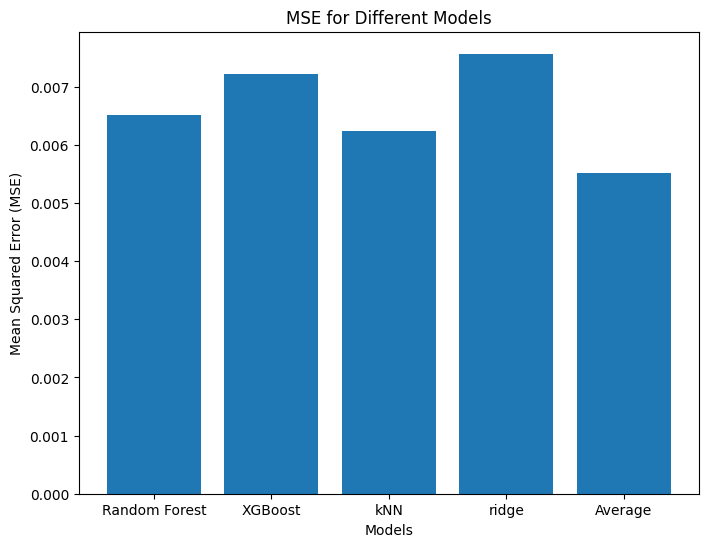

In [100]:
seed = 0 
metrics = True

mse_rfr = []
mse_xgb = []
mse_knn = []
mse_ridge = []
mse_avg = []

mse_tracker = {'Random Forest': mse_rfr, 'XGBoost': mse_xgb, 'kNN': mse_knn, 'ridge': mse_ridge, 'Average': mse_avg}


fig, axes = plt.subplots(3,2, figsize=(18, 12))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        seed_index = i * 3 + j
        seed = seed_index * 14 
        current_data = dm.f_valid[seed]

        step_pred_rfr = rfr_model.predict(current_data.reshape(1, window_size * 5)).squeeze()
        step_pred_xgb = xgb_model.predict(current_data.reshape(1, window_size * 5)).squeeze()
        step_pred_knn = knn_model.predict(current_data.reshape(1, window_size * 5)).squeeze()
        step_pred_ridge = ridge_model.predict(current_data.reshape(1, window_size * 5)).squeeze()

        average = (step_pred_rfr + step_pred_xgb + step_pred_knn + step_pred_ridge) / 4

        t_test_data = dm.t_valid[seed:seed + step][0][:, 2]

        # ax.plot(range(window_size), current_data[:, 0], label='temperature', c='gray')
        # ax.plot(range(window_size), current_data[:, 1], label='humidity', c='gray')
        ax.plot(range(window_size), current_data[:, 2], label='wind_speed', c='black')
        # ax.plot(range(window_size), current_data[:, 3], label='wind_direction', c='gray')
        # ax.plot(range(window_size), current_data[:, 4], label='wind_gusts', c='gray')
        ax.plot(range(window_size, window_size + step), t_test_data, label = 'Target', c='blue')
        ax.plot(range(window_size, window_size + step), step_pred_rfr, label = 'Reg', c='green')
        ax.plot(range(window_size, window_size + step), step_pred_xgb, label = 'XGB', c='red')     
        ax.plot(range(window_size, window_size + step), step_pred_knn, label = 'kNN', c='violet')
        ax.plot(range(window_size, window_size + step), step_pred_ridge, label = 'ridge', c='yellow')
        ax.plot(range(window_size, window_size + step), average, label = 'Average', c='orange', linewidth=2)

        mse_rfr.append(mean_squared_error(t_test_data, step_pred_rfr))
        mse_xgb.append(mean_squared_error(t_test_data, step_pred_xgb))
        mse_knn.append(mean_squared_error(t_test_data, step_pred_knn))
        mse_ridge.append(mean_squared_error(t_test_data, step_pred_ridge))
        mse_avg.append(mean_squared_error(t_test_data, average))

        if i == 0 and j == 0:  
            ax.legend(loc='upper left')

        ax.set_title(f"Seed: {seed}")

if metrics:
    for key, value in mse_tracker.items():
        print(f'Mean MSE for {key}: {np.mean(value)}')
    

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(mse_tracker.keys(), [np.mean(value) for value in mse_tracker.values()])
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Models')
plt.show()

MSE for Average model: 0.013472448473475757
MSE for kNN model: 0.018015847
MSE for Lasso model: 0.015432309882763487
MSE for Random Forest model: 0.014041705906770965
MSE for XGBoost model: 0.01391605


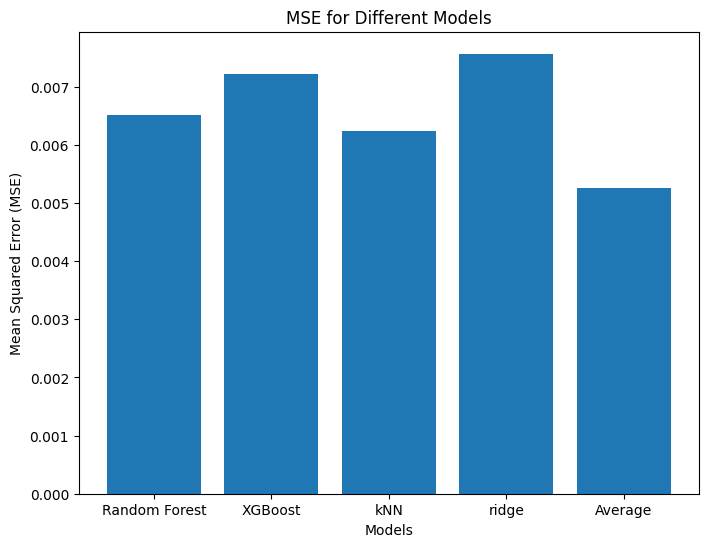

In [99]:

y_true = dm.t_test[:, :, 2]


y_pred_knn = knn_model.predict(dm.f_test.reshape(-1, window_size * 5))
y_pred_ridge = ridge_model.predict(dm.f_test.reshape(-1, window_size * 5))
y_pred_rfr = rfr_model.predict(dm.f_test.reshape(-1, window_size * 5))
y_pred_xgb = xgb_model.predict(dm.f_test.reshape(-1, window_size * 5))
y_pred_avg = (y_pred_rfr + y_pred_xgb + y_pred_knn + y_pred_ridge) / 4

mse_avg = mean_squared_error(y_true, y_pred_avg)
mse_knn = mean_squared_error(y_true, y_pred_knn)
mse_lasso = mean_squared_error(y_true, y_pred_ridge)
mse_rfr = mean_squared_error(y_true, y_pred_rfr)
mse_xgb = mean_squared_error(y_true, y_pred_xgb)

# Print MSE for each model
print("MSE for Average model:", mse_avg)
print("MSE for kNN model:", mse_knn)
print("MSE for Lasso model:", mse_lasso)
print("MSE for Random Forest model:", mse_rfr)
print("MSE for XGBoost model:", mse_xgb)

plt.figure(figsize=(8, 6))
plt.bar(mse_tracker.keys(), [np.mean(value) for value in mse_tracker.values()])
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Models')
plt.show()